# Drift Dispersion Relation Solver by Superstatistics Integral(Kappa Distribution) - Fig1

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import plasmapy
from scipy import special as sp
import scipy.optimize as op
from scipy import integrate
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
kappa_e = 3.0
kappa_i = 3.0

ae2ai = (kappa_e-1.5)/kappa_e * kappa_i/(kappa_i-1.5)
he2hi = (kappa_e-1.5)/(kappa_e-0.5) * (kappa_i-0.5)/(kappa_i-1.5)

mi2me = 1836
ve2vi = 100
kz_rho_i = 1e-3

Ln2rho_i = 10
wp_i2wc_i = 100

In [4]:
def PDRM(w2wc,ky_rho_i):
    Te2Ti = ve2vi**2/mi2me
    ky_rho_e = ky_rho_i*np.sqrt(Te2Ti/mi2me)
    kz_rho_e = kz_rho_i*np.sqrt(Te2Ti/mi2me)
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*np.sqrt(Te2Ti)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/np.sqrt(mi2me)/np.sqrt(Te2Ti)
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz
    zeta_ne = -zeta_ni*np.sqrt(Te2Ti)/np.sqrt(mi2me)
    
    re = 1 + (zeta_e-zeta_ne)*plasmapy.dispersion.plasma_dispersion_func(zeta_e)*np.i0(ky_rho_e**2)*np.exp(-ky_rho_e**2)
    ri = 1 + (zeta_i-zeta_ni)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*np.i0(ky_rho_i**2)*np.exp(-ky_rho_i**2)
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2
    return [r.real,r.imag]

def PDRK(w2wc,ky_rho_i):
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    kz_rho_e = kz_rho_i*ve2vi/mi2me
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i*np.sqrt(kappa_i/(kappa_i-0.5))
    k_l_De = k_l_Di*np.sqrt(ve2vi**2/mi2me/ae2ai*he2hi)
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz*kappa_i/(kappa_i-1.5)
    zeta_ne = -zeta_ni*ve2vi/mi2me/ae2ai
    
    integrad_e1 = lambda be: np.sqrt(be)*zeta_e *plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_e2 = lambda be: np.sqrt(be)*zeta_ne*plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_i1 = lambda bi: np.sqrt(bi)*zeta_i *plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    integrad_i2 = lambda bi: np.sqrt(bi)*zeta_ni*plasmapy.dispersion.plasma_dispersion_func(zeta_i*np.sqrt(bi))*np.i0(ky_rho_i**2/bi)*np.exp(-ky_rho_i**2/bi)
    
    terms = 100
    gl_e1 = sp.roots_genlaguerre(terms,kappa_e-0.5)
    gl_e2 = sp.roots_genlaguerre(terms,kappa_e-1.5)
    gl_i1 = sp.roots_genlaguerre(terms,kappa_i-0.5)
    gl_i2 = sp.roots_genlaguerre(terms,kappa_i-1.5)
    
    i_e1 = np.dot(gl_e1[1],integrad_e1(gl_e1[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    i_e2 = np.dot(gl_e2[1],integrad_e2(gl_e2[0]/kappa_e))/sp.gamma(kappa_e+0.5)*(kappa_e-1.5)
    i_i1 = np.dot(gl_i1[1],integrad_i1(gl_i1[0]/kappa_i))/sp.gamma(kappa_i+0.5)
    i_i2 = np.dot(gl_i2[1],integrad_i2(gl_i2[0]/kappa_i))/sp.gamma(kappa_i+0.5)*(kappa_i-1.5)
    
    re = 1 + i_e1-i_e2
    ri = 1 + i_i1-i_i2
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

#dispersion for kappa_i = infty
def PDRKM(w2wc,ky_rho_i):
    ky_rho_e = ky_rho_i*ve2vi/mi2me
    kz_rho_e = kz_rho_i*ve2vi/mi2me
    ky2kz = ky_rho_i/kz_rho_i
    k_l_Di = np.sqrt(ky_rho_i**2+kz_rho_i**2)/wp_i2wc_i
    k_l_De = k_l_Di*np.sqrt(ve2vi**2/mi2me*kappa_e/(kappa_e-0.5))
    
    wr,wi=w2wc
    wc=complex(wr,wi)

    zeta_i = wc/np.sqrt(2)/kz_rho_i
    zeta_e = zeta_i/ve2vi
    zeta_ni = 1.0/Ln2rho_i/np.sqrt(2)*ky2kz
    zeta_ne = -zeta_ni*ve2vi/mi2me*kappa_e/(kappa_e-1.5)
    
    integrad_e1 = lambda be: np.sqrt(be)*zeta_e *plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    integrad_e2 = lambda be: np.sqrt(be)*zeta_ne*plasmapy.dispersion.plasma_dispersion_func(zeta_e*np.sqrt(be))*np.i0(ky_rho_e**2/be)*np.exp(-ky_rho_e**2/be)
    
    terms = 100
    gl_e1 = sp.roots_genlaguerre(terms,kappa_e-0.5)
    gl_e2 = sp.roots_genlaguerre(terms,kappa_e-1.5)
    
    i_e1 = np.dot(gl_e1[1],integrad_e1(gl_e1[0]/kappa_e))/sp.gamma(kappa_e+0.5)
    i_e2 = np.dot(gl_e2[1],integrad_e2(gl_e2[0]/kappa_e))/sp.gamma(kappa_e+0.5)*(kappa_e-1.5)
    
    re = 1 + i_e1-i_e2
    ri = 1 + (zeta_i-zeta_ni)*plasmapy.dispersion.plasma_dispersion_func(zeta_i)*np.i0(ky_rho_i**2)*np.exp(-ky_rho_i**2)
    r = 1 + re/k_l_De**2 + ri/k_l_Di**2

    return [r.real,r.imag]

In [5]:
ktest = 1e-3

#for ky_rho_i = 1e-3 kz_rho_i = 1e-1 kappa_e = kappa_i = 2
wguess_m = -0.004
rguess_m = 0.001
wguess_k = -0.004
rguess_k = -0.001

s=op.root(lambda w:PDRM(w,ktest),[wguess_m,rguess_m])
print('M',s.success)
print(s.x[0],s.x[1])

s1=op.root(lambda w:PDRK(w,ktest),[wguess_k,rguess_k])
print('K',s1.success)
print(s1.x[0],s1.x[1])

s2=op.root(lambda w:PDRKM(w,ktest),[wguess_k,rguess_k])
print('KM',s2.success)
print(s2.x[0],s2.x[1])

M True
-0.003289228369459323 -0.00017495953329234573
K True
-0.0036214968771089012 -0.0005892551941001024
KM True
-0.0035075527368311444 -0.00013768938010436774


In [6]:
cond_u_K = (kappa_i-1.5)/kappa_i
cond_d_K = 2*kappa_e+(2*kappa_e-3)*(ve2vi**2/mi2me/ae2ai)
cond_u_KM = 1.0
cond_d_KM = 2*kappa_e+(2*kappa_e-3)*(ve2vi**2/mi2me/(kappa_e-1.5)*kappa_e)
ky_rho_i_cond_K = np.sqrt(cond_u_K/cond_d_K)
print('K',ky_rho_i_cond_K)
ky_rho_i_cond_KM = np.sqrt(cond_u_KM/cond_d_KM)
print('KM',ky_rho_i_cond_KM)

K 0.14960451081023216
KM 0.16078970373536522


In [7]:
index = np.linspace(-2,0,num=200)
ky_rho_i_list = 10**(index)

w_M_list = []
r_M_list = []
w_K_list = []
r_K_list = []
w_KM_list = []
r_KM_list = []
wgm =wguess_m
rgm =rguess_m
wgk =wguess_k
rgk =rguess_k
wgkm =wguess_k
rgkm =rguess_k

for ki in tqdm(ky_rho_i_list):
    sM=op.root(lambda w:PDRM(w,ki),[wgm,rgm])
    w_M_list.append(sM.x[0])
    r_M_list.append(sM.x[1])
    wgm = round(sM.x[0],6)
    rgm = round(sM.x[1],6)
    
    sK=op.root(lambda w:PDRK(w,ki),[wgk,rgk])
    w_K_list.append(sK.x[0])
    r_K_list.append(sK.x[1])
    wgk = round(sK.x[0],6)
    rgk = round(sK.x[1],6)
    
    sKM=op.root(lambda w:PDRKM(w,ki),[wgkm,rgkm])
    w_KM_list.append(sKM.x[0])
    r_KM_list.append(sKM.x[1])
    wgkm = round(sKM.x[0],6)
    rgkm = round(sKM.x[1],6)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 41.84it/s]


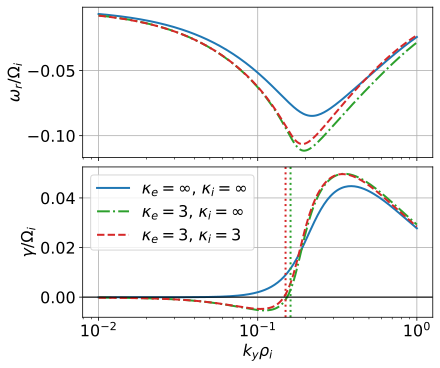

In [10]:
xticks = 10**np.linspace(-2,0,num=3)
fig = plt.figure(figsize=(6,5),layout='constrained')

ax1 = plt.subplot(211)
ax1.plot(ky_rho_i_list,w_M_list, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$', color='tab:blue', linestyle='-')
ax1.plot(ky_rho_i_list,w_KM_list,label=r'$\kappa_e=3$, $\kappa_i=\infty$',      color='tab:green',linestyle='-.')
ax1.plot(ky_rho_i_list,w_K_list, label=r'$\kappa_e=3$, $\kappa_i=3$',           color='tab:red',  linestyle='--')
ax1.set_ylabel(r'$\omega_r/\Omega_i$')
ax1.set_xscale('log')
ax1.set_xticks(xticks,())
ax1.grid()

ax2 = plt.subplot(212)
ax2.plot(ky_rho_i_list,r_M_list, label=r'$\kappa_e=\infty$, $\kappa_i=\infty$',color='tab:blue', linestyle='-')
ax2.plot(ky_rho_i_list,r_KM_list,label=r'$\kappa_e=3$, $\kappa_i=\infty$',     color='tab:green',linestyle='-.')
ax2.plot(ky_rho_i_list,r_K_list, label=r'$\kappa_e=3$, $\kappa_i=3$',          color='tab:red',  linestyle='--')
ax2.axvline(ky_rho_i_cond_K,color='tab:red',linestyle=':')
ax2.axvline(ky_rho_i_cond_KM,color='tab:green',linestyle=':')
# ax2.axvline(0.18,color='green',linestyle=':')
ax2.axhline(0,color='black',linewidth=1.1)
ax2.set_xlabel(r'$k_y\rho_i$')
ax2.set_ylabel(r'$\gamma/\Omega_i$')
ax2.set_xscale('log')
ax2.set_xticks(xticks)
ax2.legend()
ax2.grid()

# plt.savefig('./fig1_dispersion_vs_kyrhoi.pdf')
plt.show()